In [64]:
import importlib

from cocoView import *

In [65]:
image_dir = './testCOCO/filtered/test/'
annotation_path = './testCOCO/filtered/test/_annotations.coco.json'

coco_dataset = CocoDataset(annotation_path, image_dir)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()


Dataset Info:
  year: 2023
  version: 1
  description: Exported from roboflow.ai
  contributor: 
  url: https://public.roboflow.ai/object-detection/undefined
  date_created: 2023-05-22T13:05:35+00:00
ERROR: year should be type <class 'int'>

Licenses:
  id: 1
  url: https://creativecommons.org/licenses/by/4.0/
  name: CC BY 4.0


Categories:
  super_category: none
    id 0: Plastic

  super_category: Plastic
    id 1: 1
    id 2: 2
    id 3: 3
    id 4: 3 0 0 0 0



In [68]:
# importlib.reload(cocoView)

html = coco_dataset.display_image(21)
IPython.display.HTML(html)

# cocoView ctrl f
# print('  segmentations ({}):'.format(len(self.segmentations[image_id])))

Image:
  id: 21
  license: 1
  file_name: dirt_345_jpg.rf.0ee4a8d2260a53d34f89f6b67ee7f1e5.jpg
  height: 640
  width: 640
  date_captured: 2023-05-22T13:05:35+00:00


FileNotFoundError: [Errno 2] No such file or directory: './testCOCO/filtered/test/dirt_345_jpg.rf.0ee4a8d2260a53d34f89f6b67ee7f1e5.jpg'

In [ ]:
import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return annotation

In [82]:
import numpy as np
import json
import os
  
def delNoSegJSONelem(pth2json):
# delete all without segmentation
# TODO: delete pictures from json that are not in the array
    imgIDs=[]
    imgPaths=[]
    with open(pth2json) as f:
        count=0
        data = json.load(f)
        while len(list(data['annotations'])) > count:
            annot=data['annotations'][count]
            while not annot["segmentation"]:
                lastPoppedID=data['annotations'][count]["id"]
                data['annotations'].pop(count)

                if len(list(data['annotations'])) <= count:
                    break
                else:
                    annot=data['annotations'][count]
            count+=1
        for annot in data['annotations']:
            imgIDs.append(annot["image_id"])
        for img in data['images']:
            if img["id"] in imgIDs:
                imgPaths.append(img["file_name"])
        return data,imgPaths
        
        count=0
        while len(list(data['images'])) > len(imgPaths):
            img=data['images'][count]
            while annot["id"] in imgIDs:
                lastPoppedID=data['images'][count]["id"]
                print
                data['images'].pop(count)

                if len(list(data['images'])) <= count:
                    break
                else:
                    annot=data['images'][count]
            count+=1
        d2 = {}
        data['images']["id"]
        
        for img in data['images']:
            if img["id"] in :
                if 'hi' in key:
                    key.remove('hi')
                d2[tuple(key)] = value
                
folder='test'
pth2json='./testCOCO/'+folder+'/_annotations.coco.json'
data,imgPaths = delNoSegJSONelem(pth2json)
print(len(imgPaths))
with open("./testCOCO/filtered/"+folder+"/_annotations.coco.json", "w") as outF:
    json.dump(data, outF, indent = 6)

# for imgName in imgPaths:
#     src = os.path.join('./testCOCO/'+folder,imgName)
#     dst = os.path.join("./testCOCO/filtered/"+folder,imgName)
#     os.replace(src, dst)



30


In [69]:
import os
import re
import cv2


import numpy as np
import matplotlib.pyplot as plt


!pip install pycocotools
from pycocotools.coco import COCO


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
Plastic 1 2 3 3 0 0 0 0

COCO supercategories: 
none Plastic
./testCOCO/filtered/test/76_fiber_jpg.rf.0e2204a7c3604bf7ca1f793344485954.jpg


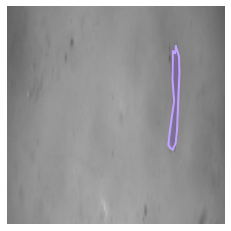

In [80]:
dataDir = './testCOCO/filtered/test/'
annFile = './testCOCO/filtered/test/_annotations.coco.json'

# initialize COCO api for instance annotations
coco=COCO(annFile)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['1']); 
imgIds = coco.getImgIds(catIds=catIds );
img = coco.loadImgs(11)[0]

randImgPath=dataDir+img['file_name']
print(randImgPath)
assert os.path.exists(randImgPath)
image = cv2.imread(randImgPath)
plt.imshow(image); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
